In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Build your own convolutional neural network using pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import os
import pandas as pd
from PIL import Image
from glob import glob


In [ ]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

model = CustomCNN(3)
print(model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code)

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [ ]:
# Transformations
transforms = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor()
])

# Load training and validation datasets
train_dataset = datasets.ImageFolder(root='/content/drive/My Drive/DogHeart/Dog_heart/Train', transform=transforms)
val_dataset = datasets.ImageFolder(root='/content/drive/My Drive/DogHeart/Dog_heart/Valid', transform=transforms)

class CustomImageDatasetLoader(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('jpg', 'jpeg', 'png'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(img_path)
        return image, filename

# Load the test dataset
test_dataset = CustomImageDatasetLoader(root_dir='/content/drive/My Drive/DogHeart/Test 2', transform=transforms)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save if the validation loss is the best.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

Epoch [1/50], Train Loss: 1.0354, Val Loss: 1.0201
Epoch [2/50], Train Loss: 0.9879, Val Loss: 0.9846
Epoch [3/50], Train Loss: 0.9722, Val Loss: 0.9573
Epoch [4/50], Train Loss: 0.9208, Val Loss: 0.8369
Epoch [5/50], Train Loss: 0.8542, Val Loss: 0.8220
Epoch [6/50], Train Loss: 0.7827, Val Loss: 0.7233
Epoch [7/50], Train Loss: 0.7709, Val Loss: 0.7447
Epoch [8/50], Train Loss: 0.7446, Val Loss: 0.7193
Epoch [9/50], Train Loss: 0.7359, Val Loss: 0.7537
Epoch [10/50], Train Loss: 0.7128, Val Loss: 0.6785
Epoch [11/50], Train Loss: 0.6769, Val Loss: 0.6793
Epoch [12/50], Train Loss: 0.6851, Val Loss: 0.6587
Epoch [13/50], Train Loss: 0.6341, Val Loss: 0.6211
Epoch [14/50], Train Loss: 0.6079, Val Loss: 0.6400
Epoch [15/50], Train Loss: 0.5956, Val Loss: 0.6406
Epoch [16/50], Train Loss: 0.5913, Val Loss: 0.6697
Epoch [17/50], Train Loss: 0.5966, Val Loss: 0.6498
Epoch [18/50], Train Loss: 0.5509, Val Loss: 0.7038
Epoch [19/50], Train Loss: 0.5250, Val Loss: 0.6373
Epoch [20/50], Train 

In [ ]:
model.load_state_dict(torch.load('/content/best_model.pt'))
model.eval()

test_predictions = []
image_paths = []
with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        image_paths.extend(paths)

# Predictions to a CSV file
def save_predictions_to_csv(predictions, filenames, filename):
    df = pd.DataFrame(list(zip(filenames, predictions)))
    df.to_csv(filename, index=False, header=False)

save_predictions_to_csv(test_predictions, image_paths, 'project_test_predictions.csv')

<ipython-input-6-df241070ce70>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


# 3. Evaluate your model using the developed software

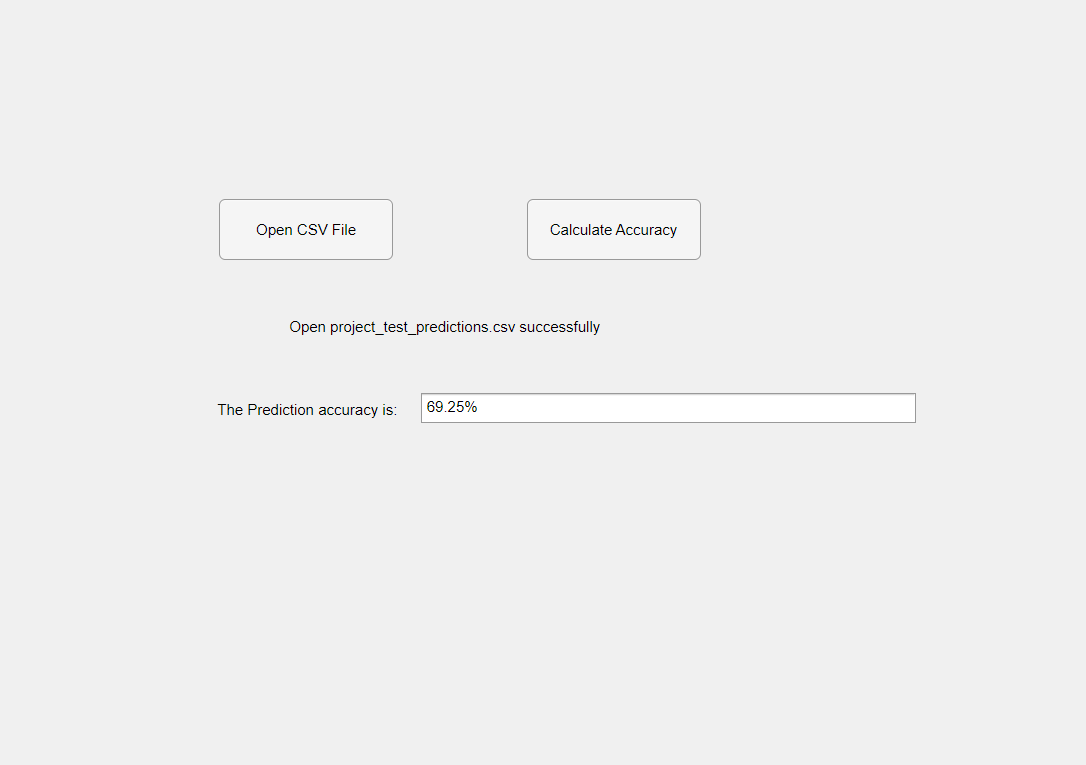

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 70%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

Paper Link: https://www.researchgate.net/publication/382109427_Assessing_Cardiomegaly_in_Dogs_Using_a_Simple_CNN_Model

Github Weight Link: https://github.com/NikhilDeekonda77/Dog_Cardiomegaly_Assessment/blob/main/best_model.pt


# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 70 % -->10 points
     < 50 % -->0 points
     >= 50 % & < 70% --> 0.5 point/percent
     

(6). Discussion - 10 points